## Importing Libraries

In [22]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
from sklearn.model_selection import train_test_split



## Zoo Dataset for Class Prediction
We have different features of animals like predator, presence of backbones ,fins,legs,etc. From these features we try to predict 7 classes of animals.

In [23]:
df=pd.read_csv("Zoo (1).csv")
df.head()

,hair,feathers,eggs,milk,airborne,aquatic,predator,toothed,backbone,breathes,venomous,fins,legs,tail,domestic,catsize,type
0,True,False,False,True,False,False,True,True,True,True,False,False,4,False,False,True,mammal
1,True,False,False,True,False,False,False,True,True,True,False,False,4,True,False,True,mammal
2,False,False,True,False,False,True,True,True,True,False,False,True,0,True,False,False,fish
3,True,False,False,True,False,False,True,True,True,True,False,False,4,False,False,True,mammal
4,True,False,False,True,False,False,True,True,True,True,False,False,4,True,False,True,mammal


In [24]:
df.shape

(101, 17)

## Feature-Target Split

In [25]:
X = df.drop(columns=["type"])
y = df["type"].values

## Encoding
Onehot Encoding for Presence/Absence of Features

Label Encoding for Target

In [26]:
# Encode all categorical features (except 'legs') using one-hot
categorical_cols = X.columns.drop('legs')
encoder = OneHotEncoder(sparse_output=False)
X_cat_encoded = encoder.fit_transform(X[categorical_cols])

# Keep 'legs' as numeric
X_num = X[['legs']].values

# Combine numeric and encoded categorical features
X_encoded = np.hstack([X_num, X_cat_encoded])

# Encode target using LabelEncoder
le = LabelEncoder()
y_encoded = le.fit_transform(y)

## Train-Test Split

In [27]:
X_train, X_test, y_train, y_test = train_test_split(
    X_encoded, y_encoded, test_size=0.2, random_state=42, stratify=y_encoded)

## Entropy Function Calculation

In [28]:
def entropy(y):
    classes = np.unique(y)
    e = 0
    for c in classes:
        p = np.sum(y == c) / len(y)
        if p > 0:
            e -= p * np.log2(p)
    return e

## Information Gain Function

In [29]:
def information_gain(y, y_left, y_right):
    """
    Computes Information Gain of a split
    y: original labels before split
    y_left, y_right: labels of left and right split
    """
    H_before = entropy(y)
    H_left = entropy(y_left)
    H_right = entropy(y_right)
    # Weighted entropy after split
    H_after = (len(y_left)*H_left + len(y_right)*H_right) / len(y)
    gain = H_before - H_after
    return gain

## Split the dataset at each node

In [30]:

def split_dataset(X, y, feature, threshold):
    left_idx = X[:, feature] <= threshold
    right_idx = X[:, feature] > threshold
    return X[left_idx], y[left_idx], X[right_idx], y[right_idx]

## Find the Best Split Function

In [31]:
def best_split(X, y):
    best_gain = -1
    best_feat = None
    best_thresh = None

    for feature in range(X.shape[1]):
        thresholds = np.unique(X[:, feature])
        for t in thresholds:
            _, y_left, _, y_right = split_dataset(X, y, feature, t)
            if len(y_left) == 0 or len(y_right) == 0:
                continue
            gain = information_gain(y, y_left, y_right)
            if gain > best_gain:
                best_gain = gain
                best_feat = feature
                best_thresh = t
    return best_feat, best_thresh

## Build The Tree Function

In [32]:
def build_tree(X, y, depth=0, max_depth=5):
    if len(np.unique(y)) == 1 or depth == max_depth:
        return {"type": "leaf", "class": np.bincount(y).argmax()}

    feat, thresh = best_split(X, y)
    if feat is None:
        return {"type": "leaf", "class": np.bincount(y).argmax()}

    X_left, y_left, X_right, y_right = split_dataset(X, y, feat, thresh)

    left_branch = build_tree(X_left, y_left, depth+1, max_depth=max_depth)
    right_branch = build_tree(X_right, y_right, depth+1, max_depth=max_depth)

    return {"type": "node", "feature": feat, "threshold": thresh,
            "left": left_branch, "right": right_branch}

## Predictions

In [33]:
def predict_tree(x, tree):
    if tree["type"] == "leaf":
        return tree["class"]
    if x[tree["feature"]] <= tree["threshold"]:
        return predict_tree(x, tree["left"])
    else:
        return predict_tree(x, tree["right"])

def predict(X, tree):
    return np.array([predict_tree(x, tree) for x in X])

## Accuracy of Decision Tree

In [34]:
tree = build_tree(X_train, y_train, max_depth=5)

y_train_pred = predict(X_train, tree)
y_test_pred = predict(X_test, tree)

train_acc = np.sum(y_train_pred == y_train) / len(y_train)
test_acc = np.sum(y_test_pred == y_test) / len(y_test)

print("Train Accuracy:", train_acc)
print("Test Accuracy:", test_acc)

Train Accuracy: 0.9875
Test Accuracy: 0.9047619047619048


Train Accuracy is 98%  higher than test accuracy 90%. This is expected as decision tree generally has the problem of overfitting. So,we need to switch to ensembles.

## Printing the Decision Tree

In [35]:
feature_names = ['legs'] + list(encoder.get_feature_names_out(categorical_cols))

In [36]:
from graphviz import Digraph

def plot_tree_graphviz(tree, features, parent=None, graph=None, edge_label=""):
    if graph is None:
        graph = Digraph()

    if tree["type"] == "leaf":
        label = f"Leaf\nClass={le.inverse_transform([tree['class']])[0]}"
    else:
        label = f"{features[tree['feature']]}\n<= {tree['threshold']}"

    node_id = str(id(tree))  # unique ID
    graph.node(node_id, label)

    if parent:
        graph.edge(parent, node_id, label=edge_label)

    if tree["type"] == "node":
        plot_tree_graphviz(tree["left"], features, node_id, graph, "True")
        plot_tree_graphviz(tree["right"], features, node_id, graph, "False")

    return graph

# Usage:
graph = plot_tree_graphviz(tree, feature_names)
graph.render("decision_tree", format="png", cleanup=True)

'decision_tree.png'

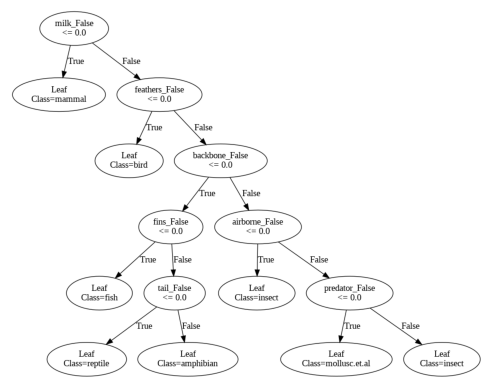

In [37]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

img = mpimg.imread("decision_tree.png")
plt.imshow(img)
plt.axis("off")
plt.show()